# Portfolio 1

In the following exercises, we are going to analyse response time data  from a recent paper [(Legrand et al., 2021)](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) using PyMC3.

In [1]:
### IMPORTS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats

sns.set_context('talk')

In [2]:
# Load data frame
df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

## Exercise 1 - Preprocessing

This data frame contains behavioral results from a lot of participants, doing a lot of different tasks. The data of interest for us are stored in the `ConfidenceRT` column. This is the time the participant takes to rate a confidence rating scale. Before we go to the analysis part, we should filter this data frame a bit.

* Here we only want to analyze the modality labeled as `Intero`, and drop the other one. 
* We only want to keep the `Subject` and the `ConfidenceRT` columns. 
* Sometimes, no responses were made by the participant, so the column potentially contains NaN values that should be removed. 
* Because we are just testing new models here, we only want to analyze a sub-sample of the data to save time and memory, so we are going to analyze subjects whose ID ends with a `7` and drop the rest of the participants.

You should end up with a data frame containing 2 columns, 1158 rows, and the response time data from 20 participants in total. If you have difficulties doing this filtering process, you can just skip this question and use the entire `ConfidenceRT` column for the next questions.

In [3]:
df.head() #get an idea of how the data looks

,TrialType,Condition,Modality,StairCond,Decision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,...,EstimatedThreshold,EstimatedSlope,StartListening,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,HeartRateOutlier,Subject
0,psiCatchTrial,Less,Intero,psiCatchTrial,Less,1.933293,99.0,0.512461,-30.0,66.5,...,NaN,NaN,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,1.603353e+09,False,sub_0019
1,psi,Less,Extero,psi,Less,2.216429,59.0,1.632995,-0.5,78.0,...,22.80555,12.549457,1.603353e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
2,psiCatchTrial,More,Intero,psiCatchTrial,Less,3.099441,25.0,0.729331,10.0,67.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
3,psiCatchTrial,Less,Extero,psiCatchTrial,Less,1.449154,100.0,0.511938,-30.0,82.0,...,NaN,NaN,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019
4,psi,Less,Intero,psi,Less,2.099316,41.0,1.243842,-0.5,65.5,...,22.80555,12.549457,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,1.603354e+09,False,sub_0019


In [3]:
filtered_df = df[(df["Modality"] == "Intero") & (df["Subject"].str.endswith("7"))][["Subject", "ConfidenceRT"]].dropna().reset_index(drop = True)


## Exercise 2 - Gaussian model
There are many ways to describe response time distribution. The most intuitive and simple model would be to use a normal distribution and use the mean and precision of this distribution as parameters of interest for each subject.

We know from the experimental design that the response time cannot be less than 0 seconds or more than 5 seconds. Our first guess will be to use a normal distribution with a mean $\mu$ and a standard deviation $\sigma$. The mean might come from another normal distribution centered at 2.5. We don't want it to be too informative so the standard deviation will be set at 10. The standard deviation might come from a HalfCauchy distribution with a beta parameter set to `2`.

* Use PyMC3 to fit this model to the responses from the first participant only (`sub_0027`) and create one plot using Arviz to synthesize your results.
* Why did you choose this plot?
* Describe what is represented in your plot
* What information should we check if we want to make sure that the MCMC chain from this model can be trusted?

In [4]:
data = filtered_df[filtered_df["Subject"] == "sub_0027"] #get subject 27

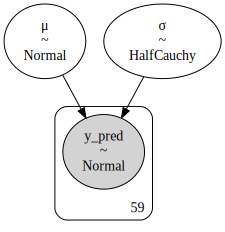

In [6]:
with pm.Model() as FirstModel:
    ## PRIORS ##
    μ = pm.Normal("μ", mu = 2.5, sd = 10)
    σ = pm.HalfCauchy("σ", beta = 2)
    
    ## LIKELIHOOD ##
    y_pred = pm.Normal("y_pred", mu = μ, sd = σ, observed = data["ConfidenceRT"].values)
    
#get plate notation to visualize what the model looks like
pm.model_to_graphviz(FirstModel) 

In [7]:
def model_dict(model):
    '''
    Description: Takes a pm.Model() object, and samples from the posterior, the prior predictive and the posterior predictive
    Input [pm.Model]: model to test
    Output [dict]: dictionary containing "model", "trace", "prior" and "posterior".
    '''
    #sample from the model
    with model:
        trace = pm.sample(tune = 2000, return_inferencedata = False)
        priorpc = pm.sample_prior_predictive(300)
        postpc = pm.sample_posterior_predictive(trace, 300)
    
    #return in dictionary format
    mod_dict = {
        "model": model,
        "trace": trace,
        "prior": priorpc,
        "posterior": postpc,
    }
    
    return mod_dict

In [8]:
Normal_dict = model_dict(FirstModel)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 95 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


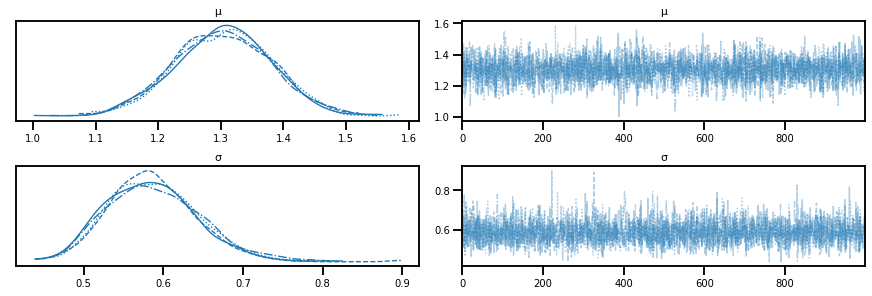

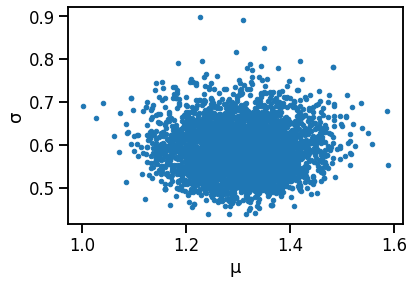

In [9]:
with Normal_dict["model"]:
    az.plot_trace(Normal_dict["trace"])
    sum_trace = az.summary(Normal_dict["trace"])
    az.plot_pair(Normal_dict["trace"])

### Small comment here:
On first glance, it does seem like we are getting a nice fit to the data. Traces look healthy, and we don't get any divergences. Furthermore, our parameter space is not compressed, and our parameters are independent from each other. But we need to do a prior predictive check, and a posterior predictive check. We also see an $R-hat$ of 1, indicating that the different chains are sampling very similar distributions.

In [10]:
def plot_pps(model_dict):
    az.plot_ppc(az.from_pymc3(posterior_predictive=model_dict["prior"], model=model_dict["model"])) #prior
    az.plot_ppc(az.from_pymc3(posterior_predictive=model_dict["posterior"], model=model_dict["model"])) #posterior

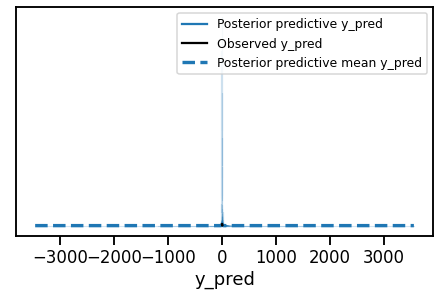

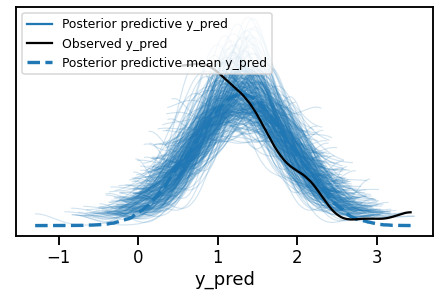

In [11]:
plot_pps(Normal_dict)

### Comments on plots:
Here is where we have clear evidence that our model is *very* wrong. In terms of our prior: If we know from our experimental design that $RT \in [0, 5]$, then our priors should reflect that information. Currently, they don't. The prior predictive plot shows samples directly from our priors and predicts $y$ from them, whereas the posterior predictive shows the models prediction of $y$ after learning from the data. This also acts as our rationale for choosing these plots. We have reason for quite strong priors in this instance ($RT \in [0, 5]$). Although much of the probability mass resides in this area in our posterior, the posterior predictive plot shows, that our model is actually a quite poor fit to the data. We really should limit all of our probability mass to be within $[0,5]$.
The posterior also reflects, that our model doesn't capture the pattern in the data. Response times are not normally distributed at all, so our posterior fails to capture data. 



## Exercise 3 - Precision

You want to compare your results with another model from the literature that describes the normal distribution using precision ($\lambda$), and not the standard deviation ($\sigma$). We know that: $$\sigma = \frac{1}{\sqrt{\lambda}}$$

* Use `az. summary` to extract the $\sigma$ value from the previous model, and convert it into a precision ($\lambda$) value.

We isolate $\lambda$:

$$ \sigma = \frac{1}{\sqrt{\lambda}} \implies \sigma \sqrt{\lambda} = 1 \implies \lambda = \frac{1}{\sigma^2}$$

In [12]:
lamb = 1/sum_trace["mean"]["σ"]**2
lamb

2.9021763420388953

## Exercise 4 - posterior predictive checks

It turns out that this gaussian model is a terrible one for many reasons. We can explore this a bit more by checking the posterior predictive.

* Extract the posterior predictive for this model using the default parameters from PyMC3.
* Plot posterior predictive checks using built-in Arviz function.
* What does this plot tells us? 
* What are the 2 main disadvantages here for response time data?

NOTE: This was exactly what we did in Exercise 2, and the reader can go back and read the reflections there.

## Exercise 5 - A better model

The normal distribution is indeed a poor fit for response time data. Other sources suggest that the Gamma distribution or the shifted Wald distribution might do a better job (see [this paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00102/full)). You can find all these distributions already implemented in PyMC3.

Using the same data from subject 27, fit, plot, and summarize the following models separately.

* The gamma model

$$ y \sim \mathcal{Gamma}(mu=\alpha, sigma=\beta)$$
$$ \alpha \sim \mathcal{Uniform}(0, 5)$$
$$ \beta \sim  \mathcal{Uniform}(0, 5)$$

* The Wald model

$$ y \sim \mathcal{Wald}(\mu, \lambda)$$
$$ \mu \sim \mathcal{Uniform}(0, 5)$$
$$ \lambda \sim  \mathcal{Uniform}(0, 20)$$

In [13]:
with pm.Model() as ModelGamma:
    ### PRIORS ###
    α = pm.Uniform("α", 0, 5)
    β = pm.Uniform("β", 0, 5)
    
    ### LIKELIHOOD ###
    y_pred = pm.Gamma("y_pred", mu = α, sigma = β, observed = data["ConfidenceRT"].values) #alternatively, these parameters could also be alpha and beta it seems.


with pm.Model() as ModelGammaAlt:
    ### PRIORS ###
    α = pm.Uniform("α", 0, 5)
    β = pm.Uniform("β", 0, 5)
    
    ### LIKELIHOOD ###
    y_pred = pm.Gamma("y_pred", alpha = α, beta = β, observed = data["ConfidenceRT"].values) #alternatively, these parameters could also be alpha and beta it seems.

with pm.Model() as ModelWald:
    ### PRIORS ###
    μ = pm.Uniform("μ", 0, 5)
    λ = pm.Uniform("λ", 0, 20)
    
    ### LIKELIHOOD ###
    y_pred = pm.Wald("y_pred", μ, λ, observed = data["ConfidenceRT"].values)

In [14]:
Gamma_dict = model_dict(ModelGamma)
GammaAlt_dict = model_dict(ModelGammaAlt)
Wald_dict = model_dict(ModelWald)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 50 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 51 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695958910530101, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 50 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,1.318,0.072,1.185,1.451,0.002,0.001,1721.0,1708.0,1736.0,1861.0,1.0
β,0.556,0.062,0.441,0.669,0.001,0.001,1777.0,1744.0,1852.0,2056.0,1.0


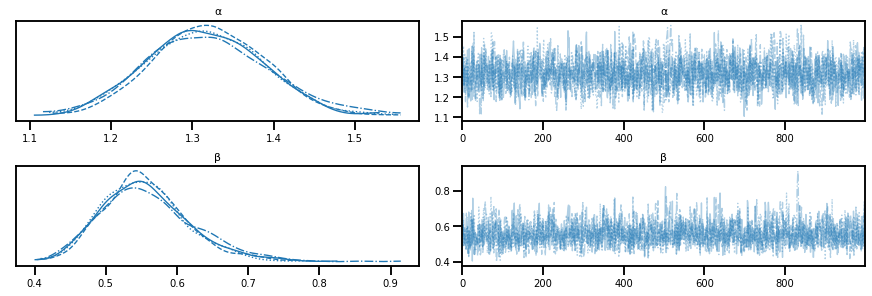

In [15]:
#with Gamma_dict["model"]:
az.plot_trace(Gamma_dict["trace"])
az.summary(Gamma_dict["trace"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,4.524,0.373,3.864,5.000,0.025,0.017,230.0,230.0,284.0,180.0,1.01
β,3.473,0.359,2.800,4.114,0.022,0.016,265.0,265.0,291.0,146.0,1.02


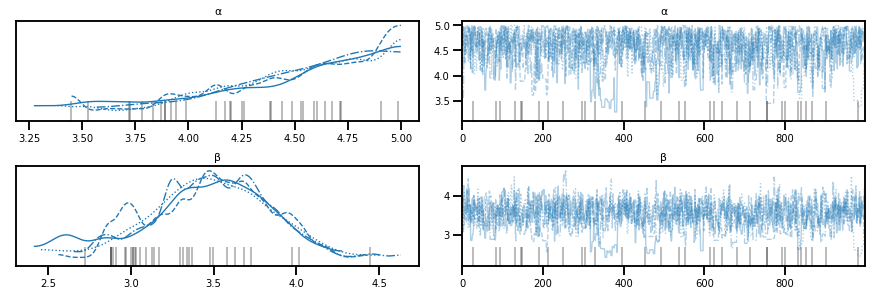

In [16]:
#with Gamma_dict["model"]:
az.plot_trace(GammaAlt_dict["trace"])
az.summary(GammaAlt_dict["trace"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,1.317,0.076,1.177,1.462,0.001,0.001,2881.0,2868.0,2898.0,2359.0,1.0
λ,7.187,1.358,4.738,9.768,0.025,0.018,2914.0,2704.0,2971.0,2433.0,1.0


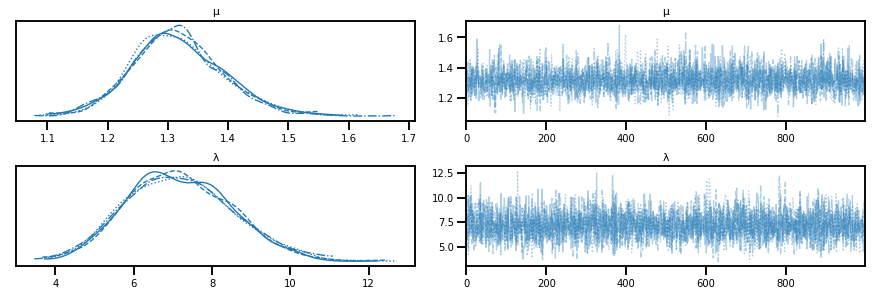

In [17]:
#with Wald_dict["model"]:
az.plot_trace(Wald_dict["trace"])
az.summary(Wald_dict["trace"])

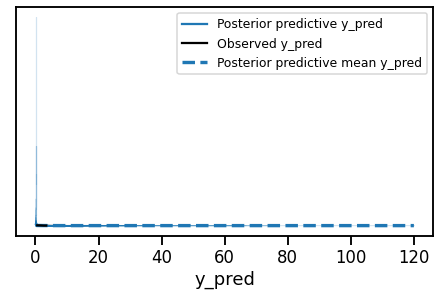

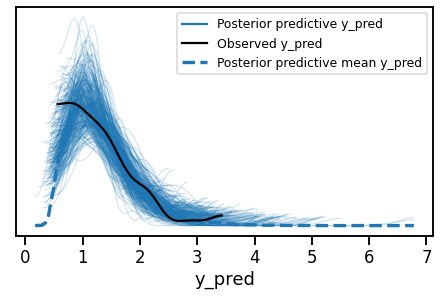

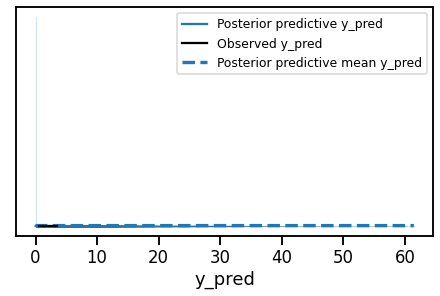

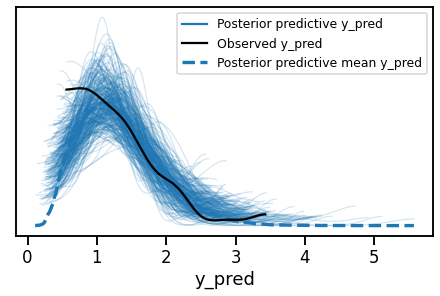

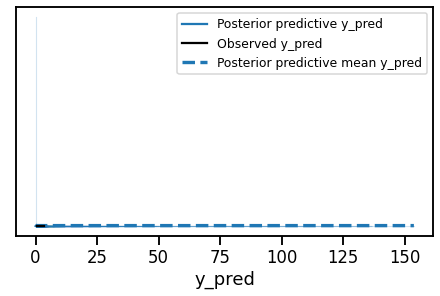

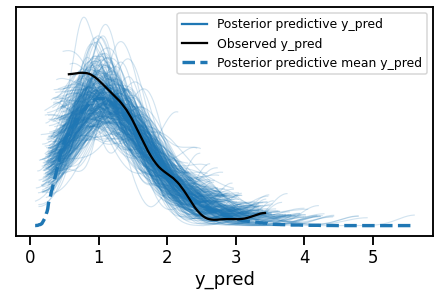

In [18]:
for i in [Wald_dict, Gamma_dict, GammaAlt_dict]:
    plot_pps(i)

## Exercise 6 - Plotting model results

Using the parameters estimates from the previous models, Matplotlib, Seaborn, and the `scipy.stats`module, try to reproduce the following plot
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/wald_gamma.png)
:

**Hint**: You can use the gamma function from Scipy to estimate the probability density function, but you will have to create your own Wald function to make it work with the parameters `mu` and `lam` estimated by PyMC3 (see the formula [here](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)).

In [19]:
def wald_function(x, μ, λ):
    return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))

In [20]:
x = np.linspace(0, 5, 1000)

In [21]:
wald_sum = az.summary(Wald_dict["trace"])
mu, lamb = wald_sum["mean"]["μ"], wald_sum["mean"]["λ"]

In [22]:
gamma_sum = az.summary(GammaAlt_dict["trace"])
alpha, beta = gamma_sum["mean"]["α"], gamma_sum["mean"]["β"]

<ipython-input-19-f408afcbd041>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))
<ipython-input-19-f408afcbd041>:2: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(λ/(2*np.pi*x**3))*np.exp(-(λ*(x-μ)**2)/(2*μ**2*x))


(0.0, 0.95)

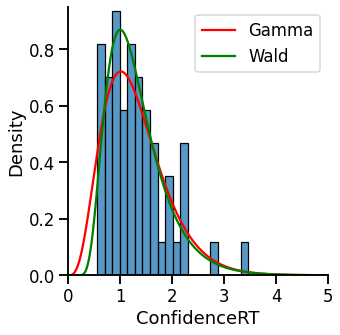

In [23]:
sns.displot(data, x = "ConfidenceRT", binwidth = 0.145, stat = "density")
plt.plot(x, stats.gamma.pdf(x, a = alpha, scale = 1/beta), color = "red")
sns.lineplot(x, wald_function(x, mu, lamb), color = "green")
plt.legend(labels = ["Gamma", "Wald"])
plt.xlim(0, 5)
plt.ylim(0, 0.95)

The density plot looks fairly close now to the original, but there are still obvious differences. First thing to note is that this plot is made using the alternative Gamma-model, where the shape parameters are $\alpha$ and $\beta$. But more importantly, it looks like the plot has been made on different data. In this case, it is fair to assume that the model has also been trained on different data. This can be seen at around $x = 1$, where it seems I have more data. If you have a comment on this regard, I am very interested.

## Exercise 6 - Model comparison

Compare the previous models (normal distribution, Gamma, Wald). Which one should we choose? What are the metrics/indexes you use to make your decision?

In [24]:
cmp_df = az.compare({'Normal': Normal_dict["trace"],
                   'Gamma': Gamma_dict["trace"],
                     "GammaAlt": GammaAlt_dict["trace"],
                    "Wald": Wald_dict["trace"]},
                    method = 'stacking',
                   ic = "waic")
cmp_df

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densiti

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Wald,0,-43.782832,1.839276,0.000000,1.000000e+00,6.199868,0.000000,True,log
Gamma,1,-45.496754,1.916655,1.713922,0.000000e+00,6.380527,1.007957,True,log
GammaAlt,2,-45.633513,1.005050,1.850681,0.000000e+00,5.426478,1.085319,False,log
Normal,3,-53.395058,3.014255,9.612226,1.643130e-13,8.422477,3.950096,True,log


In [25]:
cmp = az.compare({'Normal': Normal_dict["trace"],
                   'Gamma': Gamma_dict["trace"],
                  "GammaAlt": GammaAlt_dict["trace"],
                    "Wald": Wald_dict["trace"]},
                    method = "BB-pseudo-BMA")
cmp

C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Wald,0,-43.783333,1.839778,0.000000,0.694874,8.361307,0.000000,False,log
Gamma,1,-45.504325,1.924226,1.720991,0.157670,6.253579,1.012221,False,log
GammaAlt,2,-45.635319,1.006856,1.851986,0.145068,5.291348,1.085043,False,log
Normal,3,-53.432434,3.051631,9.649100,0.002388,6.074962,3.977367,False,log


<AxesSubplot:xlabel='Log'>

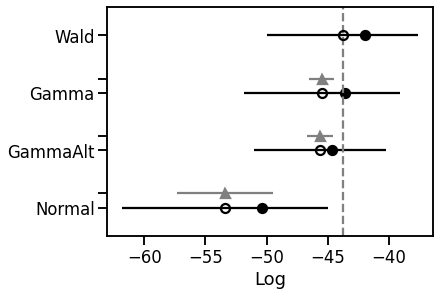

In [26]:
az.plot_compare(cmp_df)

In combination to the posterior predictive checks, the Wald model seems to be the best. The Gamma model seems to allocate too much probability in the tail of the distribution, but the data is more centralized. 

## Exercise 7 - Decision

Imagine the following (completely fictitious) situation: Previous researches have shown that the $\mu$ parameter estimated from the Wald distribution is associated with the anxiety level of the participant. The lower this parameter is, the faster the participant is at confidence rating, and the greater the anxiety level is. If $\mu$ is below 1.2, the anxiety level is considered clinically relevant and the participant should be oriented to a specialist.

You want to make a decision concerning subject 27, and you want to make it probabilistically (i.e. you want to take the decision, but also estimate how sure you are about this decision).

* Given your estimation of $\mu$ from the previous model, do you consider this score to be clinically relevant here?
* What is the probability that $\mu$ is acless thany below 1.2 for this participant?

In [27]:
mu_samples = Wald_dict["trace"]["μ"]

<AxesSubplot:>

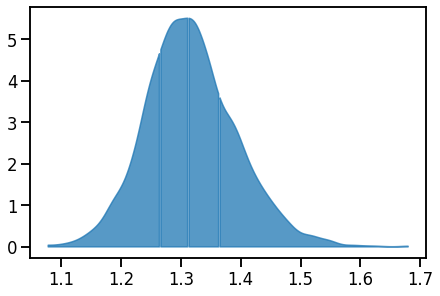

In [28]:
az.plot_kde(mu_samples, quantiles = [0.25, 0.5, 0.75])

The above plot shows the samples of $\mu$, and displays the quantiles $[0.25, 0.5, 0.75]$ as vertical lines. This gives the first indication, that less than 25% of the probability mass is below $\sim 1.28$. In order to be more precise with how much probability is less than $1.2$, we turn to the plot_posterior function:

<AxesSubplot:title={'center':'μ'}>

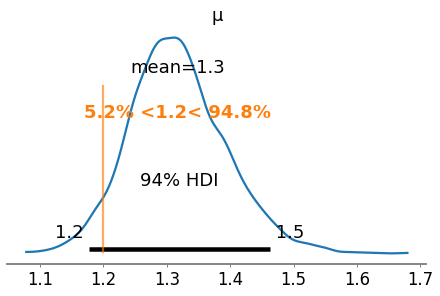

In [29]:
az.plot_posterior(data = Wald_dict["trace"], var_names = ["μ"], ref_val = 1.2)

The above plot shows that the model estimates that there is a 95% probability that $1.2 \leq \mu$. We should therefore not take actions, as the subject is not clinically relevant.

## Exercise 8 - Hierarchical model

Using the entire dataset this time (20 subjects), we are going to fit a hierarchical Wald model. Instead of fixing the prior of the parameters of the Wald function, we want to sample them from hyperpriors (i.e each participant will have its own $\mu$ and $\lambda$ parameters coming from a unique normal distributionm and we want to estimate the mean and standard deviation of these distributions). The hierarchical model for $i = 20$ participants is defined by:

$$ y_{i} \sim \mathcal{Wald}(\mu_{i}, \lambda_{i})$$
$$ \mu_{i} \sim \mathcal{N}(\mu_{\mu}, \sigma_{\mu})$$
$$ \lambda_{i} \sim  \mathcal{N}(\mu_{\lambda}, \sigma_{\lambda})$$

$$\mu_{\mu} \sim \mathcal{Uniform}(0, 100)$$
$$\mu_{\lambda} \sim \mathcal{Uniform}(0, 100)$$

$$\sigma_{\mu} \sim \mathcal{HalfCauchy}(10)$$
$$\sigma_{\lambda} \sim \mathcal{HalfCauchy}(10)$$


In [5]:
idx = pd.Categorical(filtered_df['Subject']).codes #get our idx vector for all subjects
reaction_times = filtered_df["ConfidenceRT"].values #get observed values as a np.array
groups = len(np.unique(idx)) #determine amount of subjects

In [31]:
with pm.Model() as HierachicalWald:
    ### HYPER PRIORS ###
    μ_μ = pm.Uniform("μ_μ", 0, 100)
    μ_λ = pm.Uniform("μ_λ", 0, 100)
    
    σ_μ = pm.HalfCauchy("σ_μ", 10)
    σ_λ = pm.HalfCauchy("σ_λ", 10)
    ### PRIORS ###
    μ = pm.Normal("μ", mu = μ_μ, sd = σ_μ, shape = groups)
    λ = pm.Normal("λ", mu = μ_λ, sd = σ_λ, shape = groups)
    
    ### LIKELIHOOD ###
    y_pred = pm.Wald("y_pred", μ[idx], λ[idx], observed = reaction_times)

In [32]:
Hierachical_dict = model_dict(HierachicalWald)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, μ, σ_λ, σ_μ, μ_λ, μ_μ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 110 seconds.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1049: RuntimeWarning: invalid value encountered in sqrt
  - mu / (2.0 * lam) * np.sqrt(4.0 * mu * lam * v + (mu * v) ** 2)
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1053: RuntimeWarning: overflow encountered in power
  value = (value ** -i) * (mu ** (i + 1))
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\distributions\continuous.py:1053: RuntimeWarning: invalid value encountered in multiply
  value = (value ** -i) * (mu ** (i + 1))
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


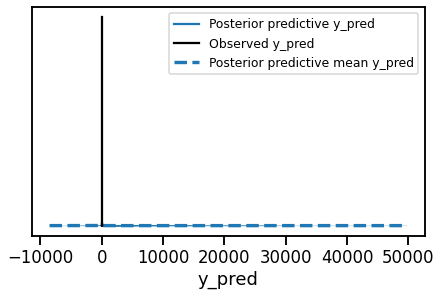

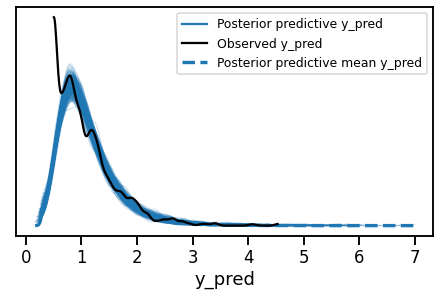

In [33]:
plot_pps(Hierachical_dict)

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'λ'}>,
        <AxesSubplot:title={'center':'λ'}>],
       [<AxesSubplot:title={'center':'μ_μ'}>,
        <AxesSubplot:title={'center':'μ_μ'}>],
       [<AxesSubplot:title={'center':'μ_λ'}>,
        <AxesSubplot:title={'center':'μ_λ'}>],
       [<AxesSubplot:title={'center':'σ_μ'}>,
        <AxesSubplot:title={'center':'σ_μ'}>],
       [<AxesSubplot:title={'center':'σ_λ'}>,
        <AxesSubplot:title={'center':'σ_λ'}>]], dtype=object)

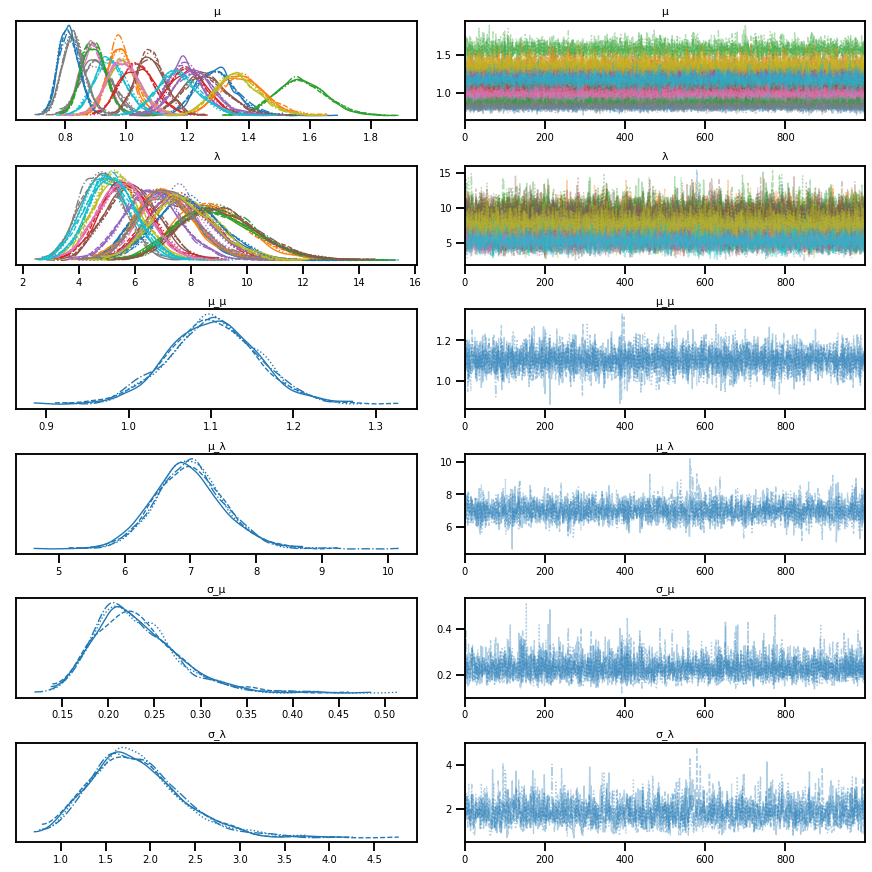

In [34]:
az.plot_trace(Hierachical_dict["trace"])